In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.7.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0)
ERROR: No matching distribution found for tensorflow==2.7.0


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Add, Multiply, Reshape, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.densenet import DenseNet121

In [4]:
# Load data
x_train = np.load('/content/drive/MyDrive/np_images/x_train.npy')
y_train = np.load('/content/drive/MyDrive/np_images/y_train.npy')
x_test = np.load('/content/drive/MyDrive/np_images/x_test.npy')
y_test = np.load('/content/drive/MyDrive/np_images/y_test.npy')

In [5]:
# Preprocess the data
x_train = tf.keras.applications.efficientnet.preprocess_input(x_train)
x_test = tf.keras.applications.efficientnet.preprocess_input(x_test)

In [6]:
def preprocess_image(img):
    # Crop the center 80% of the image
    height, width, channels = img.shape
    crop_height = int(height * 0.8)
    crop_width = int(width * 0.8)
    start_height = int((height - crop_height) / 2)
    start_width = int((width - crop_width) / 2)
    img = img[start_height:start_height+crop_height, start_width:start_width+crop_width, :]
    
    # Apply Gaussian blur with kernel size 3
    img = cv2.GaussianBlur(img, (3, 3), 0)

    img = cv2.resize(img, (224, 224))
    
    # Rescale the pixel values to [0, 1]
    img = img / 255.0
    
    return img

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
def create_datagen():
    return ImageDataGenerator(
        horizontal_flip=True,   # randomly flip images
        vertical_flip=True,     # randomly flip images
        # rotation_range=20 ,      # Degree range for random rotations
        # zoom_range=0.1
        preprocessing_function = preprocess_image
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train,batch_size=32)
print("Image data augmentated ...")

Image data augmentated ...


In [8]:
# Split data into train and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(32)

In [9]:
import keras.backend as K
from tensorflow.keras.models import Model

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


In [11]:
def spatial_attention(input_tensor):
    x = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid')(input_tensor)
    return Multiply()([input_tensor, x])

def channel_attention(input_tensor):
    x = GlobalAveragePooling2D()(input_tensor)
    x = Dense(K.int_shape(input_tensor)[-1] // 4, activation='relu')(x)
    x = Dense(K.int_shape(input_tensor)[-1], activation='sigmoid')(x)
    x = Reshape((1, 1, K.int_shape(input_tensor)[-1]))(x)
    return Multiply()([input_tensor, x])

def densenet_sa(num_classes):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

    x = base_model.output
    x = BatchNormalization()(x)
    x = spatial_attention(x)
    x = channel_attention(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = keras.models.Model(inputs=base_model.input, outputs=output)

    # Fine-tune the last few layers of the base model
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    return model

# Create model
model = densenet_sa(num_classes=5)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy',f1])

# Train model 
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)


Epoch 1/100
92/92 [==============================] - 26s 174ms/step - loss: 1.0579 - accuracy: 0.6565 - f1: 0.1916 - val_loss: 0.9016 - val_accuracy: 0.7285 - val_f1: 0.2961
Epoch 2/100
92/92 [==============================] - 13s 143ms/step - loss: 0.7588 - accuracy: 0.7224 - f1: 0.3199 - val_loss: 0.7911 - val_accuracy: 0.7299 - val_f1: 0.3001
Epoch 3/100
92/92 [==============================] - 13s 140ms/step - loss: 0.6963 - accuracy: 0.7487 - f1: 0.3567 - val_loss: 0.7341 - val_accuracy: 0.7394 - val_f1: 0.3184
Epoch 4/100
92/92 [==============================] - 13s 139ms/step - loss: 0.6501 - accuracy: 0.7614 - f1: 0.3688 - val_loss: 0.7018 - val_accuracy: 0.7422 - val_f1: 0.3487
Epoch 5/100
92/92 [==============================] - 13s 139ms/step - loss: 0.6188 - accuracy: 0.7699 - f1: 0.3961 - val_loss: 0.6786 - val_accuracy: 0.7422 - val_f1: 0.3489
Epoch 6/100
92/92 [==============================] - 13s 139ms/step - loss: 0.5937 - accuracy: 0.7774 - f1: 0.4172 - val_loss: 0.7

In [12]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/MyDrive/Densenet_with_self_model/self_dense_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


model.save('/content/drive/MyDrive/Densenet_with_self_model/Densenet_self_model.h5')
# Evaluate model on test
# test_loss, test_acc = model.evaluate(test_dataset)
# print('Test accuracy:', test_acc)

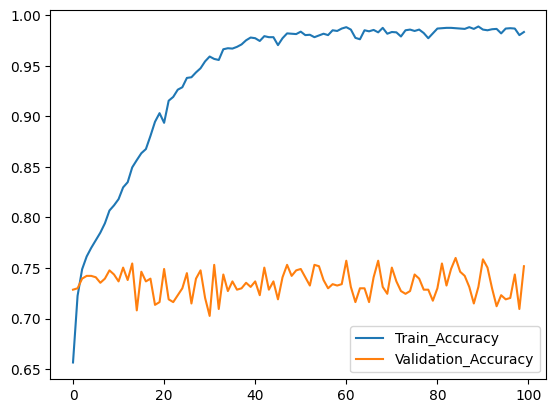

In [13]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train_Accuracy','Validation_Accuracy'])

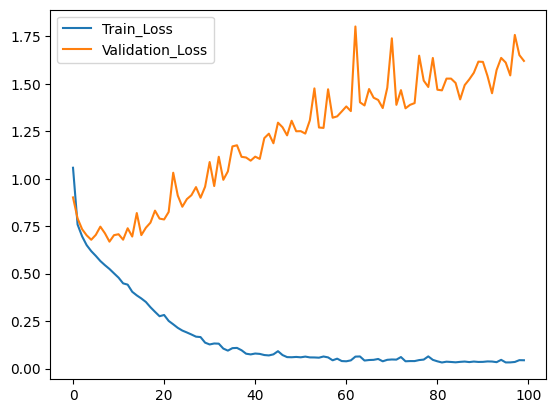

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train_Loss','Validation_Loss'])

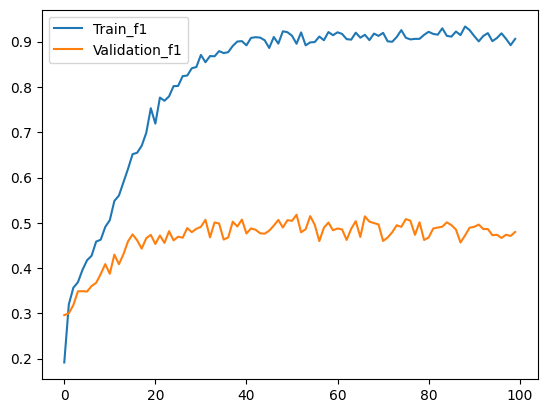

In [15]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.legend(['Train_f1','Validation_f1'])

In [16]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis = 1)
pred.shape

23/23 [==============================] - 5s 109ms/step


(733,)

In [17]:
import numpy as np

# Convert multilabel-indicator targets to multiclass labels
y_test = np.argmax(y_test, axis=1)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(pred, y_test)
print(cf_matrix)


[[342  11  14   1   3]
 [  2  31  24   3   4]
 [  6  24 154  18  38]
 [  0   1  10   9   5]
 [  1   1  11   5  15]]


<Axes: >

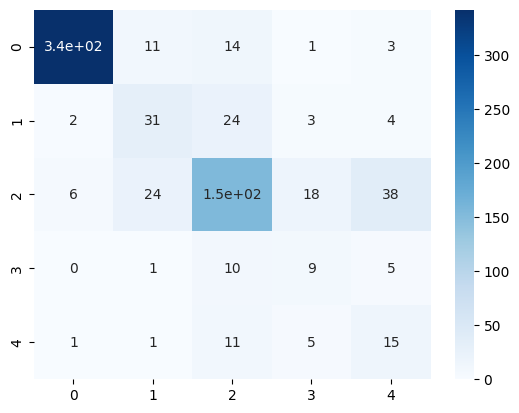

In [18]:
import seaborn as sns
sns.heatmap(cf_matrix, cmap='Blues', annot=True)

In [19]:
test_loss, test_acc, test_f1 = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)
print('Test F1 score:', test_f1)

23/23 [==============================] - 3s 113ms/step - loss: 1.6206 - accuracy: 0.7517 - f1: 0.4798
Test accuracy: 0.7517053484916687
Test F1 score: 0.4797711670398712
